Introduction
In this mini project, you will design an algorithm that can visually diagnose melanoma, the deadliest form of skin cancer. In particular, your algorithm will distinguish this malignant skin tumor from two types of benign lesions (nevi and seborrheic keratoses).

The data and objective are pulled from the 2017 ISIC Challenge on Skin Lesion Analysis Towards Melanoma Detection. As part of the challenge, participants were tasked to design an algorithm to diagnose skin lesion images as one of three different skin diseases (melanoma, nevus, or seborrheic keratosis). In this project, you will create a model to generate your own predictions.
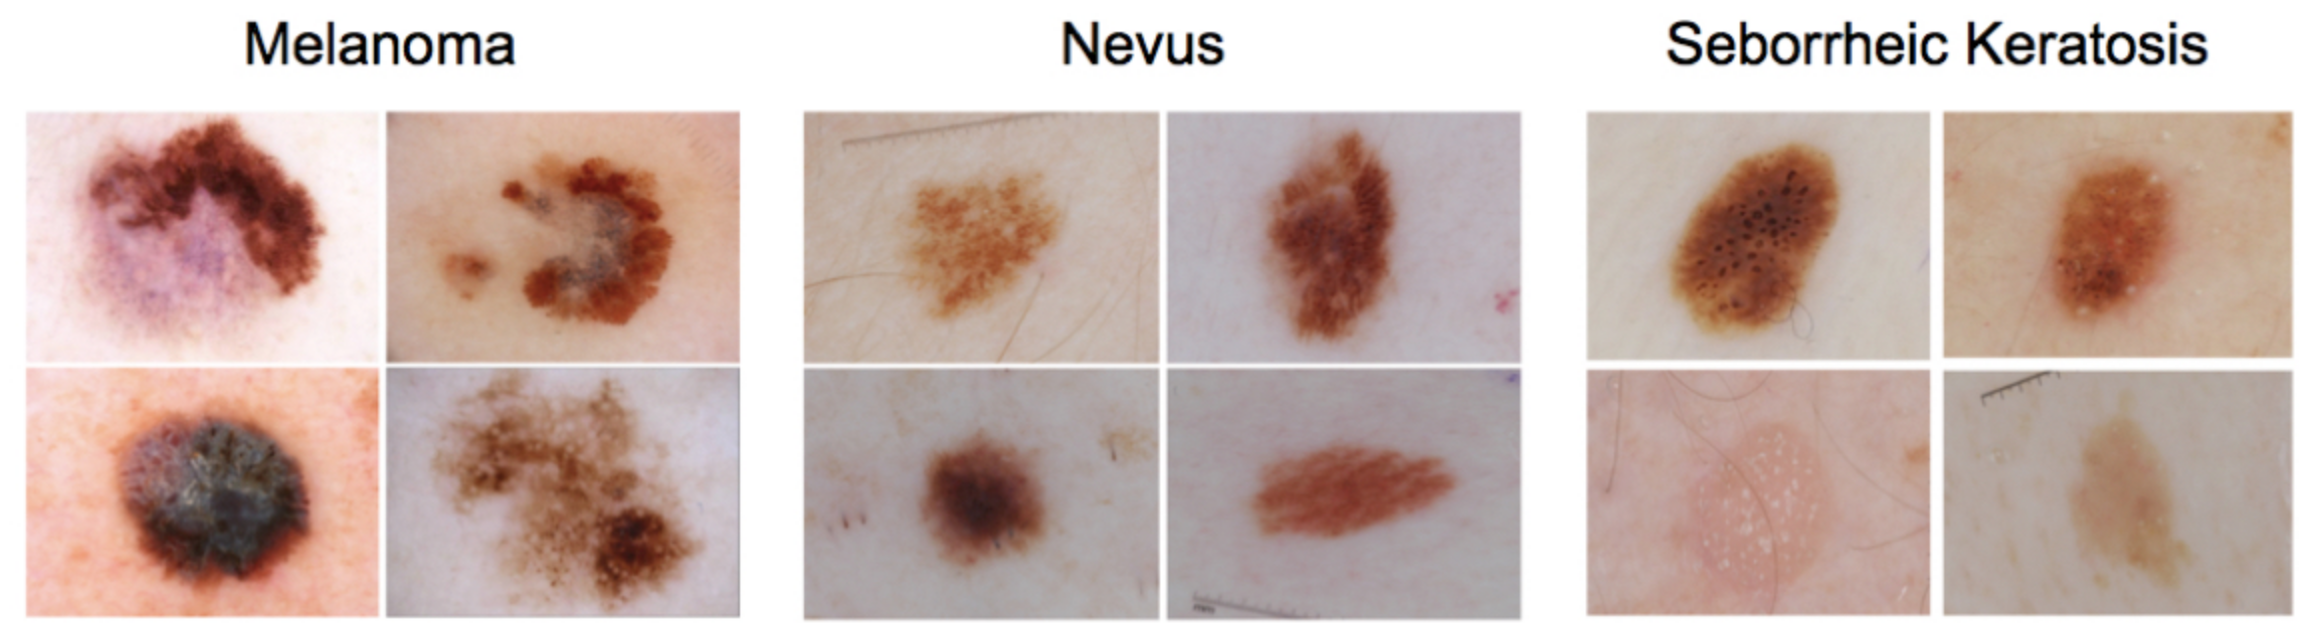

# 1. Define data loaders

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

class ImageFolderWithPath(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPath, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]

        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),        
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
     'test': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './data'


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train','valid']}

image_datasets['test'] = ImageFolderWithPath(os.path.join(data_dir, 'test'),
                                          data_transforms['test'])

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=8, pin_memory=True)
              for x in ['train','valid']}

dataloaders['test'] = torch.utils.data.DataLoader(image_datasets['test'], batch_size=16,
                                             shuffle=False, num_workers=8, pin_memory=True)

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','valid','test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Training on device: " +str(device))
print(dataset_sizes)
print(class_names)
print(len(image_datasets['train'].classes))


Training on device: cuda:0
{'train': 2000, 'valid': 150, 'test': 600}
['melanoma', 'nevus', 'seborrheic_keratosis']
3


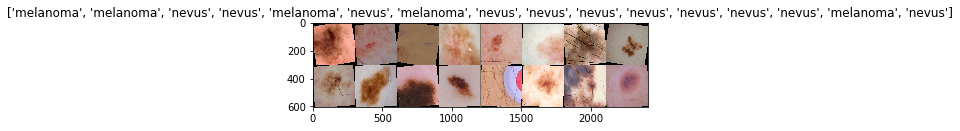

In [9]:
#load and show a sample image (taken from pytorch tutorials)
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# 2. Define model

We are using resnet-152 as our model for the image classification task. You can see the model visualized here: http://ethereon.github.io/netscope/#/gist/d38f3e6091952b45198b

In [4]:
model = models.inception.inception_v3(pretrained=True)

#freezing the feature layer parameters
#for param in model.parameters():
#    param.requires_grad = False

model.fc = nn.Linear(2048,3)

use_cuda = torch.cuda.is_available()

if use_cuda:
    model = model.to("cuda")
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [6]:
#parameters = filter(lambda p: p.requires_grad, model.parameters())
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.002,momentum=0.9)

In [10]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################        
        model.train()
        
        for batch_idx, (data, target) in enumerate(loaders['train']):  
            
            # move to GPU
            if use_cuda:    
                data, target = data.cuda(), target.cuda()
                   
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # zero the parameter gradients  
            optimizer.zero_grad() 

            # forward + backward + optimize
            outputs, aux = model(data) 
                        
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
                                   
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
                
            # move to GPU
            if use_cuda:  
                data, target = data.cuda(), target.cuda()
                                 
            outputs = model(data)
            
            loss = criterion(outputs, target)    
                
            ## update the average validation loss
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model


# train the model
model = train(10, dataloaders, model, optimizer, 
                      criterion, use_cuda, 'model.pt')

# load the model that got the best validation accuracy
model.load_state_dict(torch.load('model.pt'))

Epoch: 1 	Training Loss: 0.686343 	Validation Loss: 0.826060
Validation loss decreased (inf --> 0.826060).  Saving model ...
Epoch: 2 	Training Loss: 0.678466 	Validation Loss: 0.780165
Validation loss decreased (0.826060 --> 0.780165).  Saving model ...
Epoch: 3 	Training Loss: 0.677648 	Validation Loss: 0.826359
Epoch: 4 	Training Loss: 0.693046 	Validation Loss: 0.834996
Epoch: 5 	Training Loss: 0.658655 	Validation Loss: 0.865313
Epoch: 6 	Training Loss: 0.680706 	Validation Loss: 0.788872
Epoch: 7 	Training Loss: 0.673355 	Validation Loss: 0.765368
Validation loss decreased (0.780165 --> 0.765368).  Saving model ...
Epoch: 8 	Training Loss: 0.671156 	Validation Loss: 0.760547
Validation loss decreased (0.765368 --> 0.760547).  Saving model ...
Epoch: 9 	Training Loss: 0.683447 	Validation Loss: 0.785222
Epoch: 10 	Training Loss: 0.670273 	Validation Loss: 0.839292


## 3. Test

In [11]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target, name) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy    
model.load_state_dict(torch.load('model.pt'))    
    
# call test function    
test(dataloaders, model, criterion, use_cuda)

Test Loss: 0.725649


Test Accuracy: 69% (414/600)


## 4. Predictions

In [5]:
# load the model that got the best validation accuracy    
model.load_state_dict(torch.load('model.pt'))   

In [12]:
import csv

with open('predictions.csv', 'w', newline='') as csvfile:
    result_writger = csv.writer(csvfile)
    result_writger.writerow(['Id', 'task_1', 'task_2'])

    model.eval()
    for data, target, name in dataloaders['test']:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # move back to CPU
            if use_cuda:
                output = output.cpu()

            # convert output to probabilities using softmax    
            prediction = nn.functional.softmax(output, dim=1)
            #prediction = output
            
            # write predictions to csv file
            for idx in range(len(data)):
                result_writger.writerow([name[idx], prediction[idx][0].squeeze().item(), prediction[idx][2].squeeze().item()])

In [ ]:
Category 1 Score: 0.706
Category 2 Score: 0.833
Category 3 Score: 0.769